In [11]:
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from scipy import interpolate

import urllib.request as request

# Local Binary Patterns

## Circularly Symmetric Neighbor Set

We define a texture *T* as the collection of pixels in a gray scale image

$$T = t(g_c, g_0, ..., g_{P-1})$$

where $p_c$ is the value of the center pixel and $g_p$ corresponds to the value of a local neighboor. To calculate the coordinates of a neighbor we need the following formulas
$$i = -R\sin\big(\frac{2\pi p}{ P}\big)$$

and

$$j = R\cos\big(\frac{2\pi p}{P}\big)$$

In [2]:
def neighbor_coordinate(center_coordinates, p, P, R):
    x_0, y_0 = center_coordinates
    
    x = x_0 + R * np.cos(2 * np.pi * p / P)
    y = y_0 - R * np.sin(2 * np.pi * p / P)
        
    return x, y

def calculate_neighborhood(center_coordinates, P, R):
    return np.array([neighbor_coordinate(center_coordinates, p, P, R) for p in range(P)])

In [115]:
def plot_neigborhood(x, y):
    plt.scatter(x, y)
    plt.axis('square')
    plt.grid(True)
    plt.xticks(np.arange(-2, 3, 1.0))
    plt.yticks(np.arange(-2, 3, 1.0))
    plt.show()

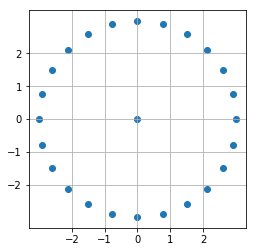

In [116]:
R = 3
P = 24
center_coordinates = np.array([0, 0])

coordinates = calculate_neighborhood(center_coordinates, P, R)
coordinates = np.concatenate((np.array([center_coordinates]), coordinates))

x = coordinates[:, 0]
y = coordinates[:, 1]

plot_neigborhood(x, y)

### Interpolation

When a neighbor is not located in the center of a pixel, that neighbor value should be calculated by interpolation. Thus, we need to define a function that given a coordinate, interpolates the value.

In [3]:
def interpolate2d(gray_img, kind='cubic'):
    """
    Returns a function f(x,y) that returns the interpolated value
    of gray_img where (x,y) is the coordinate.
    """
    assert gray_img.ndim == 2, 'It should be a two dimentional image (gray)'
    h, w = gray_img.shape

    x = np.arange(0, w)
    y = np.arange(0, h)

    return interpolate.interp2d(x, y, gray_img, kind=kind)

In [13]:
def calculate_neiborhood_values(neigborhood, interpolation_function):
    gray_values = np.apply_along_axis(lambda pt: interpolation_function(*pt), axis=1, arr=neigborhood)
    return gray_values.ravel()

### Joint Difference Distribution

The joint difference distribution is a highly discriminative texture operator. It records the ocurrences of various patterns in the neighborhood of each pixel in a P-dimentional histogram.

$$T \approx t(g_0 - g_c, g_1 - g_c, ... g_{p-1} - g_c)$$

where $g_0$ is the gray value of the center pixel and $g_p$ is the gray value of the $p$ neighbor. This distribution is invariant against gray-scale shifts.

In [59]:
def joint_difference_distribution(gray_img, center_coordinates, P, R):
    neigborhood = calculate_neighborhood(center_coordinates, P, R)
    f = interpolate2d(gray_img, kind='cubic')
    g_p = calculate_neiborhood_values(neigborhood, f)
    g_c = f(*center_coordinates)
    
    return np.round(g_p - g_c, 15)

def binary_joint_distribution(gray_img, center_coordinates, P, R):
    T = joint_difference_distribution(gray_img, center_coordinates, P, R)
    return np.where(T >= 0, 1, 0)

### Local Binary Pattern

$LBP_{P,R}$ operater is by definition invariant against any monotonic transformation of the gray scale. As long as the order of the gray values stays the same, the output of the $LBP_{P,R}$ operator remains constant.

$$LBP_{P,R} = \sum_{p=0}^{P-1} s(g_p - g_c) 2^p$$

where 

$$s(x) = 
\begin{cases} 
    1 & x\geq0 \\
    0 & x<0
\end{cases}
$$

In [58]:
def LBP(gray_img, center_coordinates, P, R):
    s = binary_joint_distribution(gray_img, center_coordinates, P, R)
    p = np.arange(0, P)
    binomial_factor = 2 ** p
    return np.sum(binomial_factor * s)

## Conversion RGB a YUV

According to [1], converting from RGB to Y'UV we need the following equations:

$$Y' = W_R R + W_G G + W_b B$$

$$U = U_{max} \frac{B - Y'}{1 - W_B}$$

$$V = V_{max} \frac{R - Y'}{1 - W_R}$$

$$W_R = 0.299;\hspace{0.5em}W_G = 1 - W_R - W_B;\hspace{0.5em}W_B = 0.114;\hspace{0.5em}U_{max} = 0.436;\hspace{0.5em}V_{max} = 0.615$$

where R, G, B are the matrix representation of red, green and blue channels. The previous equations, can be represented as a matrix multiplication

$$
\begin{bmatrix}
        Y'  \\
        U \\
        V
\end{bmatrix} =
\begin{bmatrix}
        0.299 & 0.587 & 1.114 &  \\
        -0.14713 & -0.28886 & 0.436 \\
        0.615 & -0.51499 & -0.10001
\end{bmatrix}
\begin{bmatrix}
        R  \\
        G \\
        B
\end{bmatrix}
$$

*Hint: I took more precise weights from [2]

In [189]:
def rgb2yuv(rgb):
    error_message = 'The image must be RBG'
    assert len(rgb.shape)== 3, error_message
    assert rgb.shape[-1] == 3, error_message
    
    W = np.array([
        [ 0.299     ,  0.587     ,  0.114      ],
        [-0.14714119, -0.28886916,  0.43601035 ],
        [ 0.61497538, -0.51496512, -0.10001026 ]
    ])
    
    return rgb @ W.T

# Color Moments

### Mean
$$\mu_i = \frac{1}{N} \sum_{j=1}^N p_{ij}$$

where *N* is the number of pixes in the image and $p_{ij}$ is the value of the j-th pixel of the i-th color channel. 

### Standard Deviation

$$\sigma_i = \sqrt{\frac{1}{N} \sum_{j=1}^N (p_{ij} - \mu_i) ^ 2}$$

where $\mu_i$ is the mean of the i-th color channel.

In [206]:
def color_moment(image, order=1):
    dim = image.ndim
    axis = tuple([i for i in range(img.ndim - 1)])
    
    if order == 1:
        return np.mean(image, axis=axis)
    if order == 2:
        return np.std(image, axis=axis)
    else:
        raise ValueError('Order should be 1 for mean or 2 for std')

## Auxiliary Functions

In [7]:
def load_image(url, as_gray=False):
    image_stream = request.urlopen(url)
    return skimage.io.imread(image_stream, as_gray=as_gray, plugin='pil')

import skimage.color

url = 'https://www.propertyfinder.ae/property/9607847b4ffe15366c4cae076dafb4f3/668/452/MODE/e71028/5993980-3b974o.webp'
img = load_image(url, False)
img_rgb = skimage.color.rgba2rgb(img)

In [205]:
axis = tuple([i for i in range(img.ndim - 1)])
np.mean(img, axis=axis)

array([203.00454732, 190.1900204 , 178.4292764 , 255.        ])

In [214]:
color_moment(img_rgb, order=1)

array([0.79609626, 0.74584322, 0.69972265])

In [190]:
rgb2yuv(img_rgb)

array([[[ 0.56658039, -0.05881788,  0.04996041],
        [ 0.56658039, -0.05881788,  0.04996041],
        [ 0.56658039, -0.05881788,  0.04996041],
        ...,
        [ 0.51092941, -0.0468702 ,  0.05405783],
        [ 0.51092941, -0.0468702 ,  0.05405783],
        [ 0.51092941, -0.0468702 ,  0.05405783]],

       [[ 0.56658039, -0.05881788,  0.04996041],
        [ 0.56658039, -0.05881788,  0.04996041],
        [ 0.56658039, -0.05881788,  0.04996041],
        ...,
        [ 0.51092941, -0.0468702 ,  0.05405783],
        [ 0.51092941, -0.0468702 ,  0.05405783],
        [ 0.51092941, -0.0468702 ,  0.05405783]],

       [[ 0.56658039, -0.05881788,  0.04996041],
        [ 0.56658039, -0.05881788,  0.04996041],
        [ 0.56658039, -0.05881788,  0.04996041],
        ...,
        [ 0.51602353, -0.04744722,  0.0564695 ],
        [ 0.51602353, -0.04744722,  0.0564695 ],
        [ 0.51602353, -0.04744722,  0.0564695 ]],

       ...,

       [[ 0.49478824, -0.02348817,  0.04413594],
        [ 0

In [61]:
gray_img = skimage.color.rgb2gray(img_rgb)

R = 1
P = 4
center_coordinates = [300, 300]

print(binary_joint_distribution(gray_img, center_coordinates, P, R))
print(LBP(gray_img, center_coordinates, P, R))

[1 1 0 1]
11


[1] https://www.itu.int/dms_pubrec/itu-r/rec/bt/R-REC-BT.601-7-201103-I!!PDF-E.pdf

[2] https://github.com/scikit-image/scikit-image/blob/master/skimage/color/colorconv.py#L384